# Assignment 3: Reinforcement Learning
In this assignment you will apply the RL algorithms you learnt from the tutorials to a simulated robot car in a pybullet environment.

You will be asked to (percentages are allocation of assignment marks):
* Train the robot to drive to the green goal marker which spawns at random locations (60%)
* Modify the epsilon-greedy function to incorporate prior knowledge (20%)
* Modify the reward function (10%)
* Add obstacles to the environment (10%)

It is highly recommended to install pybullet and run your code locally since things will run much faster. It will also make editing the gym environment code easier.



## Simple Car Environment
---

![simple_car.gif](https://media0.giphy.com/media/v1.Y2lkPTc5MGI3NjExODU0NmVlMzU1MGU1YzJjMjA5ODE5NjM0MTg0MTU1ZmM1OTA1NzRkNCZjdD1n/VI3OuvQShK3gzENiVz/giphy.gif)

*(code for this tutorial adapted from: https://gerardmaggiolino.medium.com/creating-openai-gym-environments-with-pybullet-part-2-a1441b9a4d8e*)

---

This is a simple car environment with a continuous state space and discrete action space with the goal of driving towards a green marker. Driving within 1.5 metres of the green marker causes the episode to end or if a certain amount of time has passed.

We can instantiate the environment as follows:


```
env = gym.make('SimpleDriving-v0', apply_api_compatibility=True, renders=False, isDiscrete=True, render_mode='tp_camera')
```


### Action Space

*   0: Reverse-Left
*   1: Reverse
*   2: Reverse-Right
*   3: Steer-Left (no throttle)
*   4: No throttle and no steering
*   5: Steer-Right (no throttle)
*   6: Forward-right
*   7: Forward
*   8: Forward-left

### Observation Space
Two dimensional array with distance in (x, y) from goal position.

###Rewards
Negative euclidean distance from the goal.

### Interacting with the Environment
We can sample actions randomly, get the agent to perform that action and then observe how the environment state changes:
```
state = env.reset()  # this needs to be called once at the start before sending any actions
action = env.action_space.sample()
state, reward, done, _, info = env.step(action)
```


---

## Installing and Modifying Gym Environment Code

For installing in collab you would have already been familiar with using the following command:
```
pip install git+https://github.com/fredsukkar/simple-car-env-template
```

To edit the gym environment first create a github account and then go to https://github.com/fredsukkar/simple-car-env-template and create a new repository using the repository as a template as follows:
![sdlfk](https://i.ibb.co/MMsLv1G/github-template.jpg)


Once you have your own copy of the repository you can then edit the files in the browser via github or alternatively (recommended) you can [clone the repository](https://docs.github.com/en/repositories/creating-and-managing-repositories/cloning-a-repository) and modify the code locally.

To install the package from github you can use the usual:
```
pip install git+https://github.com/<your repo>
```

To install the package locally:
```
cd /path/to/cloned_repo
python setup.py install
```

Note that for both methods you will need to install the package again after you've made any changes for them to take any effect.

The main file you will be modifying is: https://github.com/fredsukkar/Gym-Medium-Post/blob/main/simple_driving/envs/simple_driving_env.py.

There are four main functions that you have been calling via the gym environment object:
```
class SimpleDrivingEnv(gym.Env):
    metadata = {'render.modes': ['human']}  
  
    def __init__(self):
        pass

    def step(self, action):
        pass

    def reset(self):
        pass

    def render(self):
        pass
```

Parts 3 and 4 of the assignment will ask you to modify one of these functions.

---

Before we can execute any code we first need to install the following packages:

In [1]:
import gym
from simple_driving.envs import simple_driving_env
# import pybullet_envs
import pybullet as p
import numpy as np
import math
from collections import defaultdict
import pickle
import torch
import random
import matplotlib.pyplot as plt

######################### renders image from third person perspective for validating policy ##############################
# env = gym.make("SimpleDriving-v0", apply_api_compatibility=True, renders=False, isDiscrete=True, render_mode='tp_camera')
##########################################################################################################################

######################### renders image from onboard camera ###############################################################
# env = gym.make("SimpleDriving-v0", apply_api_compatibility=True, renders=False, isDiscrete=True, render_mode='fp_camera')
##########################################################################################################################

######################### if running locally you can just render the environment in pybullet's GUI #######################

##########################################################################################################################

pybullet build time: Apr 10 2024 13:56:47


## Part 1

Train the robot to drive to the green goal marker. Use any of the RL algorithms you learnt in the tutorials.

You can save the model after training to save you having to retrain everytime you open colab:
```
from google.colab import drive
drive.mount('/content/drive')
torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/simple_driving_qlearning.pkl")  # this will save to folder "Colab Notebooks" on your google drive
```

You can then load the model:
```
model.load_state_dict(torch.load("/content/drive/My Drive/Colab Notebooks/simple_driving_qlearning.pkl"))
```

Once loaded you can even continue your training again using the learnt weights, that way you don't have to start from scratch again if you decide you want to train for longer. But keep in mind the epsilon greedy function will start from completely random again so you might want to set epsilon starting value appropriately.

### Training 
__Action Space__ 9 Discrete Actions

__Environment Space__ 8 Continous observations 

In [2]:
# Hyper parameters that will be used in the DQN algorithm

EPISODES = 2500                 # number of episodes to run the training for
LEARNING_RATE = 0.00025         # the learning rate for optimising the neural network weights
MEM_SIZE = 50000                # maximum size of the replay memory - will start overwritting values once this is exceed
REPLAY_START_SIZE = 10000       # The amount of samples to fill the replay memory with before we start learning
BATCH_SIZE = 32                 # Number of random samples from the replay memory we use for training each iteration
GAMMA = 0.99                    # Discount factor
EPS_START = 0.15                 # Initial epsilon value for epsilon greedy action sampling
EPS_END = 0.0001                # Final epsilon value
EPS_DECAY = 4 * MEM_SIZE        # Amount of samples we decay epsilon over
MEM_RETAIN = 0.15                # Percentage of initial samples in replay memory to keep - for catastrophic forgetting
NETWORK_UPDATE_ITERS = 5000     # Number of samples 'C' for slowly updating the target network \hat{Q}'s weights with the policy network Q's weights

FC1_DIMS = 128                   # Number of neurons in our MLP's first hidden layer
FC2_DIMS = 128                   # Number of neurons in our MLP's second hidden layer

# metrics for displaying training status
best_reward = 0
average_reward = 0
episode_history = []
episode_reward_history = []
np.bool = np.bool_

#### Training Code

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# for creating the policy and target networks - same architecture
class Network(torch.nn.Module):
    def __init__(self, env):
        super().__init__()
        self.input_shape = 2
        self.action_space = env.action_space.n

        # build an MLP with 2 hidden layers
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(self.input_shape, FC1_DIMS),   # input layer
            torch.nn.ReLU(),     # this is called an activation function
            torch.nn.Linear(FC1_DIMS, FC2_DIMS),    # hidden layer
            torch.nn.ReLU(),     # this is called an activation function
            torch.nn.Linear(FC2_DIMS, self.action_space)    # output layer
            )

        self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        self.loss = nn.MSELoss()  # loss function

    def forward(self, x):
        return self.layers(x)

# handles the storing and retrival of sampled experiences
class ReplayBuffer:
    def __init__(self, env):
        self.mem_count = 0
        self.states = np.zeros((MEM_SIZE, 2),dtype=np.float32)
        self.actions = np.zeros(MEM_SIZE, dtype=np.int64)
        self.rewards = np.zeros(MEM_SIZE, dtype=np.float32)
        self.states_ = np.zeros((MEM_SIZE, 2),dtype=np.float32)
        self.dones = np.zeros(MEM_SIZE, dtype=np.bool)

    def add(self, state, action, reward, state_, done):
        # if memory count is higher than the max memory size then overwrite previous values
        if self.mem_count < MEM_SIZE:
            mem_index = self.mem_count
        else:
            ############ avoid catastropic forgetting - retain initial 10% of the replay buffer ##############
            mem_index = int(MEM_SIZE*MEM_RETAIN)
            ##################################################################################################

        self.states[mem_index]  = state
        self.actions[mem_index] = action
        self.rewards[mem_index] = reward
        self.states_[mem_index] = state_
        self.dones[mem_index] =  1 - done

        self.mem_count += 1

    # returns random samples from the replay buffer, number is equal to BATCH_SIZE
    def sample(self):
        MEM_MAX = min(self.mem_count, MEM_SIZE)
        batch_indices = np.random.choice(MEM_MAX, BATCH_SIZE, replace=True)

        states  = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.states_[batch_indices]
        dones   = self.dones[batch_indices]

        return states, actions, rewards, states_, dones

class DQN_Solver:
    def __init__(self, env):
        self.memory = ReplayBuffer(env)
        self.policy_network = Network(env)  # Q
        self.target_network = Network(env)  # \hat{Q}
        self.target_network.load_state_dict(self.policy_network.state_dict())  # initially set weights of Q to \hat{Q}
        self.learn_count = 0    # keep track of the number of iterations we have learnt for

    # epsilon greedy
    def choose_action(self, observation):
        # only start decaying epsilon once we actually start learning, i.e. once the replay memory has REPLAY_START_SIZE
        if self.memory.mem_count > REPLAY_START_SIZE:
            eps_threshold = EPS_END + (EPS_START - EPS_END) * \
                math.exp(-1. * self.learn_count / EPS_DECAY)
        else:
            eps_threshold = 1.0
        # if we rolled a value lower than epsilon sample a random action
        if random.random() < eps_threshold:
            return np.random.choice(np.array(range(9)), p=[0.2,0.1,0.2,0,0,0,0.2,0.1,0.2])    # sample random action with set priors (if we flap too much we will die too much at the start and learning will take forever)

        # otherwise policy network, Q, chooses action with highest estimated Q-value so far
        state = torch.tensor(observation).float().detach()
        state = state.unsqueeze(0)
        self.policy_network.eval()  # only need forward pass
        with torch.no_grad():       # so we don't compute gradients - save memory and computation
            ################ retrieve q-values from policy network, Q ################################
            q_values = self.policy_network(state)
            ##########################################################################################
        return torch.argmax(q_values).item()

    # main training loop
    def learn(self):
        states, actions, rewards, states_, dones = self.memory.sample()  # retrieve random batch of samples from replay memory
        states = torch.tensor(states , dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        states_ = torch.tensor(states_, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.bool)
        batch_indices = np.arange(BATCH_SIZE, dtype=np.int64)

        self.policy_network.train(True)
        q_values = self.policy_network(states)                # get current q-value estimates (all actions) from policy network, Q
        q_values = q_values[batch_indices, actions]           # q values for sampled actions only

        self.target_network.eval()                            # only need forward pass
        with torch.no_grad():                                 # so we don't compute gradients - save memory and computation
            ###### get q-values of states_ from target network, \hat{q}, for computation of the target q-values ###############
            q_values_next = self.target_network(states_)
            ###################################################################################################################

        q_values_next_max = torch.max(q_values_next, dim=1)[0]  # max q values for next state

        q_target = rewards + GAMMA * q_values_next_max * ~dones  # our target q-value

        ###### compute loss between target (from target network, \hat{Q}) and estimated q-values (from policy network, Q) #########
        loss = self.policy_network.loss(q_target, q_values)
        ###########################################################################################################################

        #compute gradients and update policy network Q weights
        self.policy_network.optimizer.zero_grad()
        loss.backward()
        self.policy_network.optimizer.step()
        self.learn_count += 1

        # set target network \hat{Q}'s weights to policy network Q's weights every C steps
        if  self.learn_count % NETWORK_UPDATE_ITERS == NETWORK_UPDATE_ITERS - 1:
            print("updating target network")
            self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.policy_network.state_dict())

    def returning_epsilon(self):
        return self.exploration_rate

#### Run Training 

In [4]:
env = simple_driving_env.SimpleDrivingEnv(renders=False)

argv[0]=
argv[0]=


In [5]:
# set manual seeds so we get same behaviour everytime - so that when you change your hyper parameters you can attribute the effect to those changes

env.action_space.seed(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
episode_batch_score = 0
episode_reward = 0
agent = DQN_Solver(env)  # create DQN agent

for i in range(EPISODES):
    state = env.reset()  # this needs to be called once at the start before sending any actions
    for j in range(35):
        # sampling loop - sample random actions and add them to the replay buffer
        action = agent.choose_action(state)
        state_, reward, done, _ = env.step(action)
        if reward > 0:
            reward *= 5
        if done == True:
          reward = 50
          print("Reached!")

        ####### add sampled experience to replay buffer ##########
        agent.memory.add(state, action, reward, state_, done)
        ##########################################################

        # only start learning once replay memory reaches REPLAY_START_SIZE
        if agent.memory.mem_count > REPLAY_START_SIZE:
            agent.learn()

        state = state_
        episode_batch_score += reward
        episode_reward += reward

        if done:
            break

    episode_history.append(i)
    episode_reward_history.append(episode_reward)
    episode_reward = 0.0

    # save our model every batches of 100 episodes so we can load later. (note: you can interrupt the training any time and load the latest saved model when testing)
    if i % 100 == 0 and agent.memory.mem_count > REPLAY_START_SIZE:
        torch.save(agent.policy_network.state_dict(), "weights.pt")
        print("average total reward per episode batch since episode ", i, ": ", episode_batch_score/ float(100))
        episode_batch_score = 0
    elif agent.memory.mem_count < REPLAY_START_SIZE:
        pcnt = str(agent.memory.mem_count/REPLAY_START_SIZE*100)
        print("waiting for buffer to fill..." + pcnt + "%")
        episode_batch_score = 0



waiting for buffer to fill...0.35000000000000003%
waiting for buffer to fill...0.7000000000000001%
waiting for buffer to fill...1.05%
waiting for buffer to fill...1.4000000000000001%
waiting for buffer to fill...1.7500000000000002%
waiting for buffer to fill...2.1%
waiting for buffer to fill...2.45%
waiting for buffer to fill...2.8000000000000003%
waiting for buffer to fill...3.15%
waiting for buffer to fill...3.5000000000000004%
waiting for buffer to fill...3.85%
waiting for buffer to fill...4.2%
waiting for buffer to fill...4.55%
waiting for buffer to fill...4.9%
waiting for buffer to fill...5.25%
waiting for buffer to fill...5.6000000000000005%
waiting for buffer to fill...5.949999999999999%
waiting for buffer to fill...6.3%
waiting for buffer to fill...6.65%
waiting for buffer to fill...7.000000000000001%
waiting for buffer to fill...7.35%
waiting for buffer to fill...7.7%
waiting for buffer to fill...8.05%
waiting for buffer to fill...8.4%
waiting for buffer to fill...8.75%
waitin

KeyboardInterrupt: 

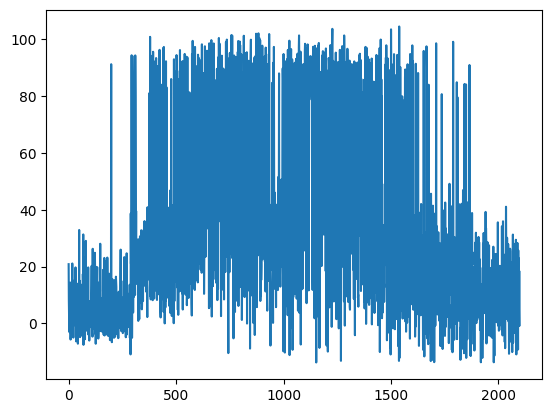

In [6]:
plt.plot(episode_history, episode_reward_history)
plt.show()

#### Testing

In [8]:
env = simple_driving_env.SimpleDrivingEnv(renders=True)


argv[0]=
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=3
argv[0] = --unused
argv[1] = 
argv[2] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 3090/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.161.07
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 535.161.07
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 3090/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


In [9]:
model = Network(env)
model.load_state_dict(torch.load('weights.pt'))
state = env.reset()
model.eval()
for i in range(40):
    state = torch.tensor(state, dtype=torch.float32) 
    actions = model(state).detach().numpy()
    action = np.argmax(actions)
    state_, reward, done, _ = env.step(action)
    if done:
        break

/tmp/ipykernel_9844/18412932.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32)


: 

## Part 2

Incorporate prior knowledge into the epsilon-greedy function by choosing a non-uniform distribution to sample from when performing exploration. For example, for training flappy bird we used the following to sample flapping actions less often to avoid flying off into the sky during early stages of training:

```
return np.random.choice(np.array(range(2)), p=[0.9,0.1])
```

Note that you will need to change the parameters to suit the car's action space and also choose a suitable distribution.

## Part 3

Modify the reward to give a bonus of 50 if the goal is reached. You can do this either in the `simulate` function or directly by modifying the `step` function in the gym environment code.


## Part 4

Add obstacles to the environment. You can do this by modifying the `reset` function in the gym environment code. For example you can add objects as follows:
```
self.obstacle = self._p.loadURDF(fileName=<path to urdf file here>,
                   basePosition=[0, 0, 0])
```

An example urdf file: https://github.com/fredsukkar/simple-car-env-template/blob/main/simple_driving/resources/simplegoal.urdf

**Note:** you will need to add features to your state so that the agent learns to avoid obstacles. For example, you could add the x, y distance from the agent to the closest obstacle in the environment. Then your state would become: `[x_goal, y_goal, x_obstacle, y_obstacle]`.

---

Here is some code to help you get started.